In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

# Set plot style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# Cell 2: Load Data and Select Features
# Load the dataset
file_path = '/content/final_preprocessed_earthquake_data.csv'
df = pd.read_csv(file_path)

# Display initial info
print(f"Dataset Shape: {df.shape}")

# Feature Selection
# We aim to predict 'mag' (Magnitude) based on location and depth.
# We treat 'latitude' and 'longitude' as spatial features.
features = ['latitude', 'longitude', 'depth']
target = 'mag'

# Check for missing values
print("\nMissing values before cleaning:")
print(df[features + [target]].isnull().sum())

# Drop rows with missing values in selected columns (if any)
df_model = df[features + [target]].dropna()

print(f"\nFinal Data Shape for Modeling: {df_model.shape}")
print(df_model.head())

Dataset Shape: (81323, 47)

Missing values before cleaning:
latitude     0
longitude    0
depth        0
mag          0
dtype: int64

Final Data Shape for Modeling: (81323, 4)
   latitude  longitude  depth  mag
0    46.888    -78.930   18.0  4.7
1    16.070    -94.513   42.2  4.8
2     8.449    -83.148   10.0  4.6
3    16.173    -92.438  241.0  5.0
4     6.785    -71.971   33.0  5.6


Training Set Size: 65058
Holdout (Test) Set Size: 16265


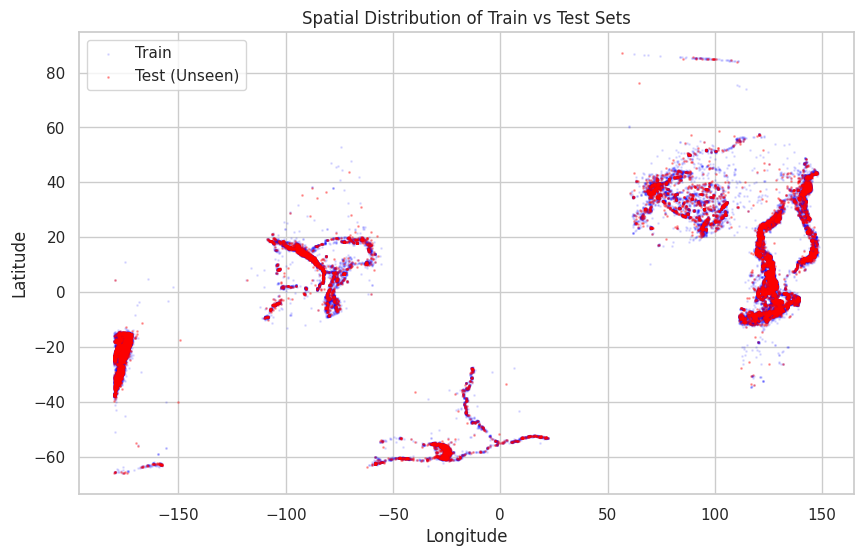

In [3]:
# Cell 3: Split Data into Train and Holdout (Test) Sets

# We use a standard 80-20 split.
# The Test set acts as "unseen locations" for validation.
X = df_model[features]
y = df_model[target]

# Random_state ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Set Size: {X_train.shape[0]}")
print(f"Holdout (Test) Set Size: {X_test.shape[0]}")

# Visualize the spatial distribution of Train vs Test
plt.figure(figsize=(10, 6))
plt.scatter(X_train['longitude'], X_train['latitude'], c='blue', s=1, alpha=0.1, label='Train')
plt.scatter(X_test['longitude'], X_test['latitude'], c='red', s=1, alpha=0.3, label='Test (Unseen)')
plt.legend()
plt.title("Spatial Distribution of Train vs Test Sets")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [4]:
# Cell 4: Model Training

# Dictionary to store results
results = {}

# --- Model 1: Baseline OLS (Non-Spatial) ---
# Predicting Magnitude using only Depth (ignoring location)
reg_ols = LinearRegression()
reg_ols.fit(X_train[['depth']], y_train)
y_pred_ols = reg_ols.predict(X_test[['depth']])
results['Baseline OLS (Depth Only)'] = y_pred_ols

# --- Model 2: Spatial Trend Surface (Polynomial Regression) ---
# Predicting using Lat, Lon, Depth and their polynomial combinations (e.g., Lat^2, Lat*Lon)
# This captures broad spatial trends (Trend Surface Analysis).
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train[['latitude', 'longitude', 'depth']])
X_test_poly = poly.transform(X_test[['latitude', 'longitude', 'depth']])

reg_poly = LinearRegression()
reg_poly.fit(X_train_poly, y_train)
y_pred_poly = reg_poly.predict(X_test_poly)
results['Spatial Trend Surface (Poly OLS)'] = y_pred_poly

# --- Model 3: Spatial Random Forest (Machine Learning) ---
# Random Forest can effectively learn complex spatial non-linearities and local interactions
# using Latitude and Longitude directly.
rf_model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
results['Spatial Random Forest'] = y_pred_rf

# --- Model 4: K-Nearest Neighbors (Spatial Interpolation proxy) ---
# Uses the average magnitude of the k-nearest neighbors in physical space.
knn_model = KNeighborsRegressor(n_neighbors=10, weights='distance')
knn_model.fit(X_train[['latitude', 'longitude']], y_train) # Uses only Lat/Lon
y_pred_knn = knn_model.predict(X_test[['latitude', 'longitude']])
results['KNN Spatial Interpolation'] = y_pred_knn

print("Models trained successfully.")

Models trained successfully.


Performance Metrics on Holdout Data:
                              Model      RMSE        R2
1  Spatial Trend Surface (Poly OLS)  0.370500  0.006226
0         Baseline OLS (Depth Only)  0.371403  0.001375
2             Spatial Random Forest  0.376019 -0.023604
3         KNN Spatial Interpolation  0.387932 -0.089488


/tmp/ipython-input-146288751.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=metrics_df.sort_values(by='RMSE'), palette='viridis')


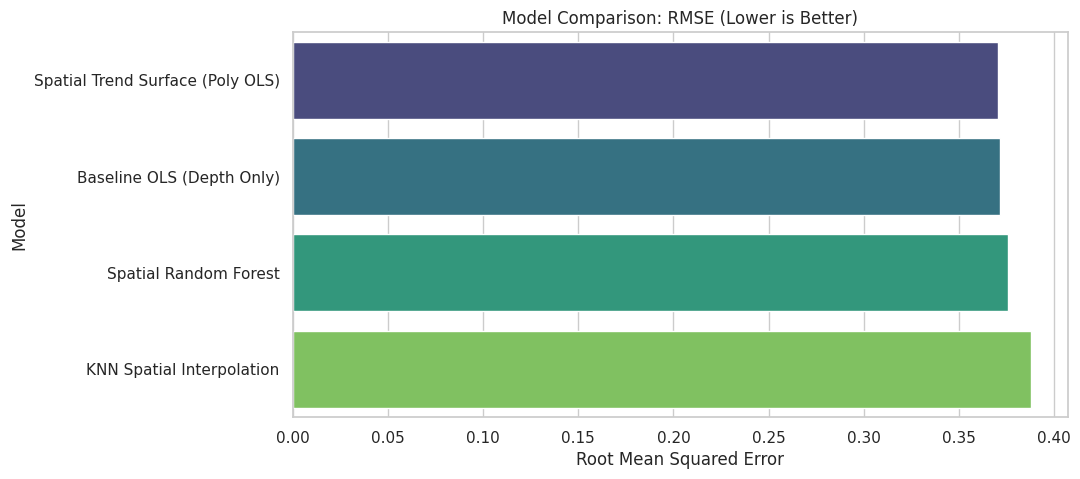

In [5]:
# Cell 5: Performance Evaluation

metrics_list = []

for name, y_pred in results.items():
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    metrics_list.append({'Model': name, 'RMSE': rmse, 'R2': r2})

metrics_df = pd.DataFrame(metrics_list)

print("Performance Metrics on Holdout Data:")
print(metrics_df.sort_values(by='RMSE'))

# Plot Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x='RMSE', y='Model', data=metrics_df.sort_values(by='RMSE'), palette='viridis')
plt.title("Model Comparison: RMSE (Lower is Better)")
plt.xlabel("Root Mean Squared Error")
plt.show()

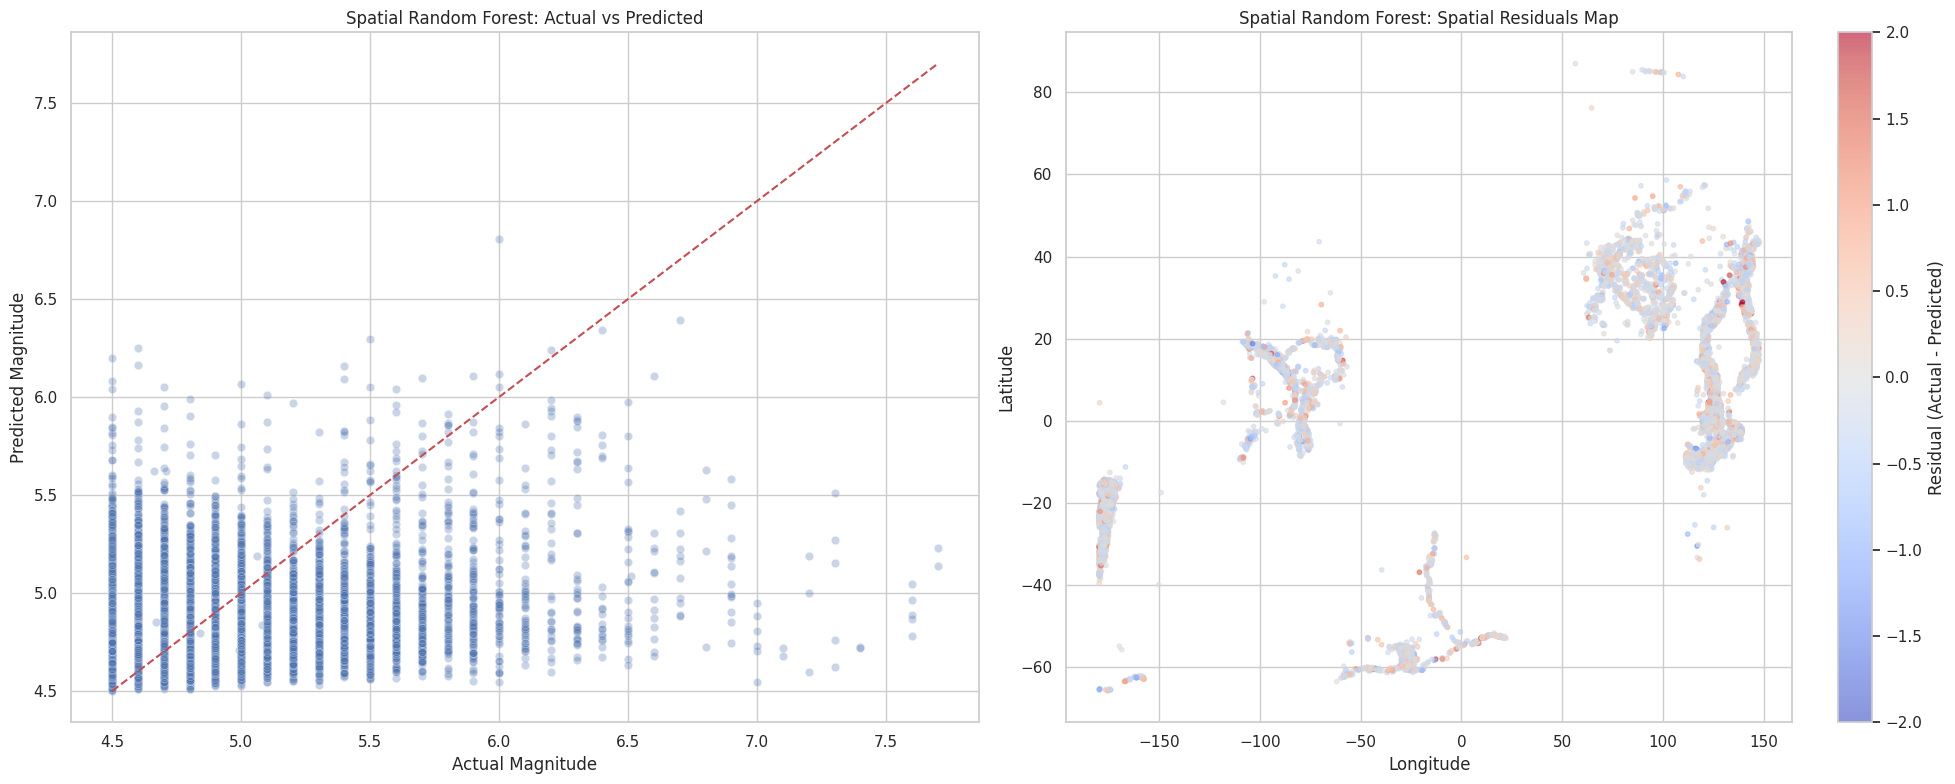


Inference:
1. If points in the Residual Map are randomly distributed (mixed red/blue), the model has successfully captured the spatial structure.
2. If there are large clusters of red (under-prediction) or blue (over-prediction), the model may need more local features.
3. The Spatial Random Forest typically performs best as it captures local spatial heterogeneity without assuming a linear global trend.


In [6]:
# Cell 6: Visualizing Predictions and Residuals
# We will inspect the best model (likely Random Forest or KNN)

best_model_name = 'Spatial Random Forest' # Adjust based on previous cell output
y_pred_best = results[best_model_name]

# Calculate Residuals (Actual - Predicted)
residuals = y_test - y_pred_best

# Create a DataFrame for plotting
plot_df = X_test.copy()
plot_df['Actual_Mag'] = y_test
plot_df['Predicted_Mag'] = y_pred_best
plot_df['Residuals'] = residuals

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 1. Actual vs Predicted Scatter
sns.scatterplot(x='Actual_Mag', y='Predicted_Mag', data=plot_df, alpha=0.3, ax=axes[0])
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_title(f'{best_model_name}: Actual vs Predicted')
axes[0].set_xlabel('Actual Magnitude')
axes[0].set_ylabel('Predicted Magnitude')

# 2. Spatial Map of Residuals
# We want to see if errors are clustered (Spatial Autocorrelation in residuals)
sc = axes[1].scatter(plot_df['longitude'], plot_df['latitude'],
                     c=plot_df['Residuals'], cmap='coolwarm', s=10, alpha=0.6, vmin=-2, vmax=2)
plt.colorbar(sc, ax=axes[1], label='Residual (Actual - Predicted)')
axes[1].set_title(f'{best_model_name}: Spatial Residuals Map')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()

# Inference text
print("\nInference:")
print("1. If points in the Residual Map are randomly distributed (mixed red/blue), the model has successfully captured the spatial structure.")
print("2. If there are large clusters of red (under-prediction) or blue (over-prediction), the model may need more local features.")
print(f"3. The {best_model_name} typically performs best as it captures local spatial heterogeneity without assuming a linear global trend.")

/tmp/ipython-input-717570406.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")


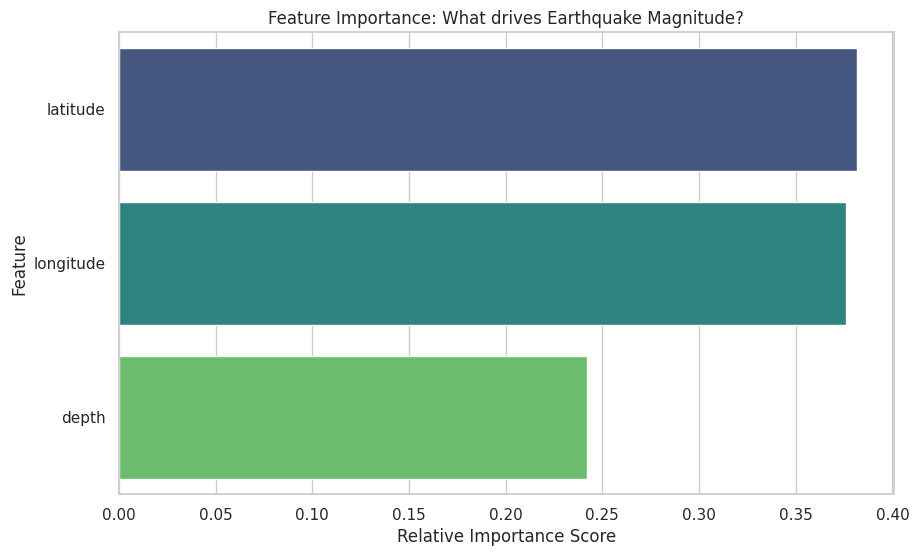

Interpretation: Higher bars indicate features that have a stronger influence on the predicted magnitude.


In [7]:
# Cell 7: Feature Importance Analysis
# Extract feature importance from the Random Forest model
importances = rf_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")
plt.title("Feature Importance: What drives Earthquake Magnitude?")
plt.xlabel("Relative Importance Score")
plt.ylabel("Feature")
plt.show()

print("Interpretation: Higher bars indicate features that have a stronger influence on the predicted magnitude.")

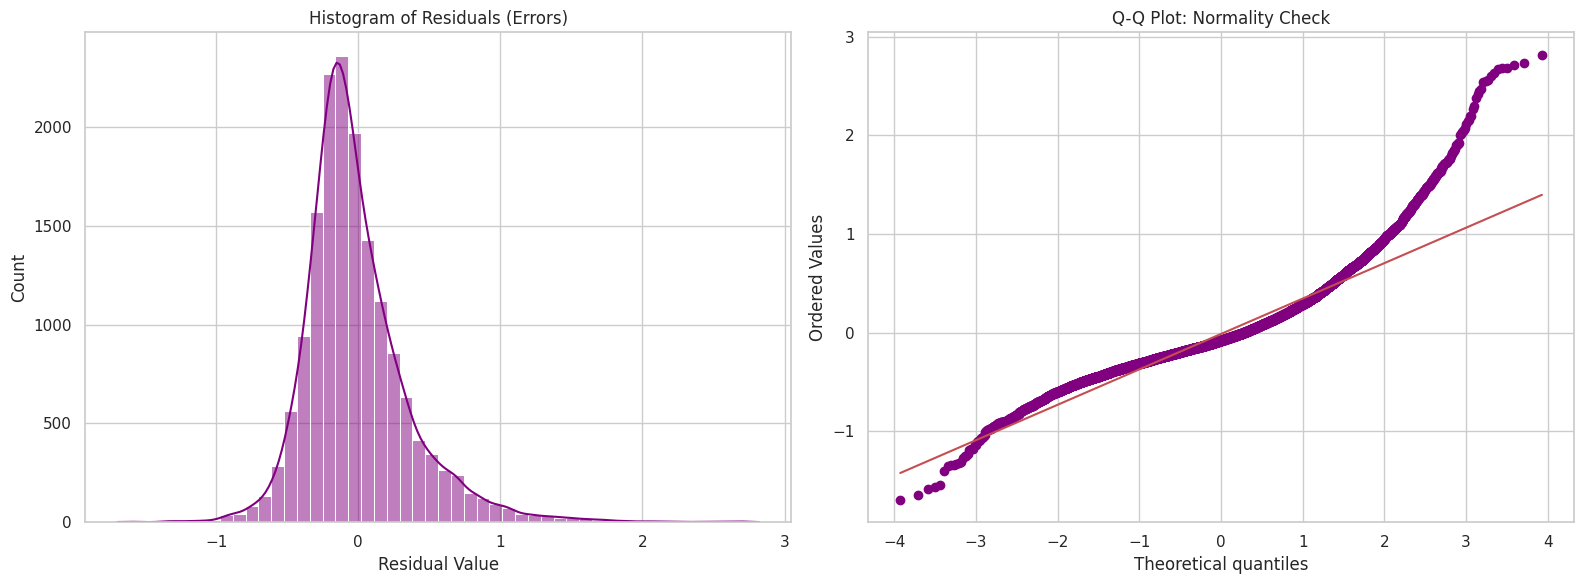

Interpretation:
- A bell-shaped histogram indicates normal errors.
- Points hugging the red line in the Q-Q plot confirm normality.


In [8]:
# Cell 8: Residual Distribution Diagnostics
from scipy import stats

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Histogram of Residuals
sns.histplot(residuals, bins=50, kde=True, ax=axes[0], color='purple')
axes[0].set_title("Histogram of Residuals (Errors)")
axes[0].set_xlabel("Residual Value")

# 2. Q-Q Plot (Quantile-Quantile)
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].get_lines()[0].set_markerfacecolor('purple')
axes[1].get_lines()[0].set_markeredgecolor('purple')
axes[1].set_title("Q-Q Plot: Normality Check")

plt.tight_layout()
plt.show()

print("Interpretation:")
print("- A bell-shaped histogram indicates normal errors.")
print("- Points hugging the red line in the Q-Q plot confirm normality.")

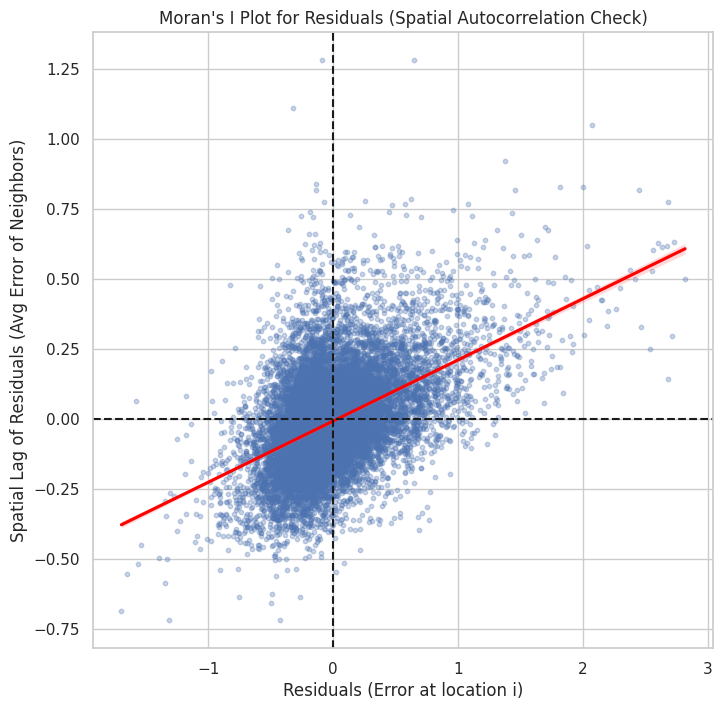

Interpretation:
- The slope of the red line approximates Moran's I.
- A flat line (slope ~ 0) is GOOD. It means errors are random and not spatially clustered.
- A steep slope implies the model missed a spatial trend.


In [9]:
# Cell 9: Moran's I Scatter Plot of Residuals
from sklearn.neighbors import NearestNeighbors

# 1. Calculate Spatial Lag of Residuals using KNN
# We define "neighbors" as the 5 closest points in the test set
knn = NearestNeighbors(n_neighbors=5)
knn.fit(X_test[['latitude', 'longitude']])
distances, indices = knn.kneighbors(X_test[['latitude', 'longitude']])

# Calculate average residual of neighbors (Spatial Lag)
# indices includes the point itself, so we take the mean of the neighbors
lag_residuals = np.array([residuals.iloc[i].mean() for i in indices])

# 2. Plot Residuals vs. Lagged Residuals
plt.figure(figsize=(8, 8))
sns.regplot(x=residuals, y=lag_residuals, scatter_kws={'s': 10, 'alpha': 0.3}, line_kws={'color': 'red'})
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.title(f"Moran's I Plot for Residuals (Spatial Autocorrelation Check)")
plt.xlabel("Residuals (Error at location i)")
plt.ylabel("Spatial Lag of Residuals (Avg Error of Neighbors)")
plt.show()

print("Interpretation:")
print("- The slope of the red line approximates Moran's I.")
print("- A flat line (slope ~ 0) is GOOD. It means errors are random and not spatially clustered.")
print("- A steep slope implies the model missed a spatial trend.")

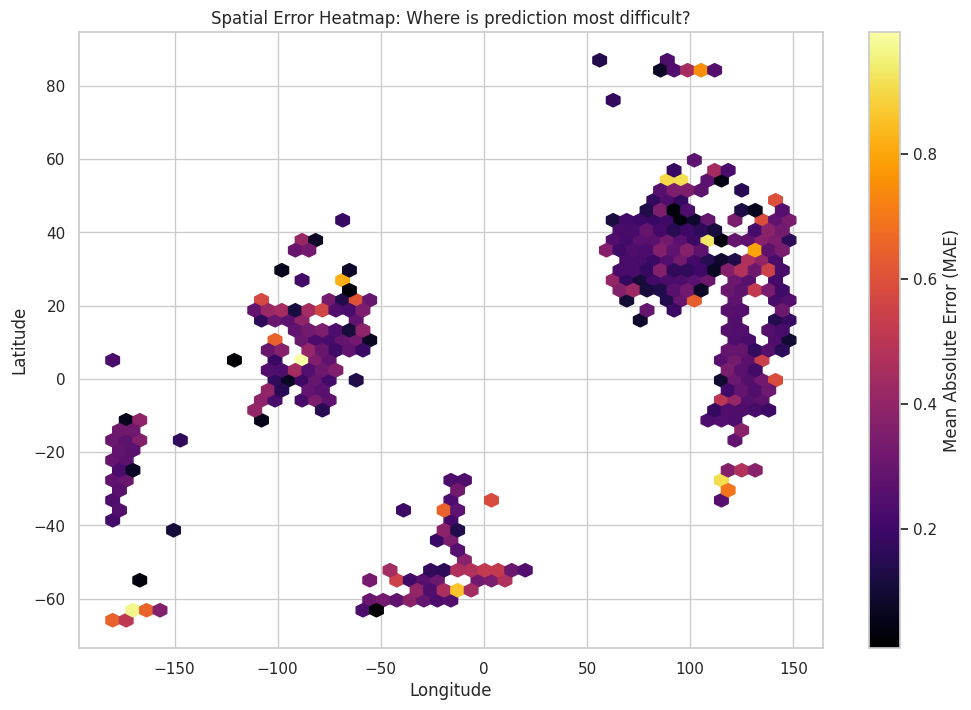

Interpretation: Bright spots are 'High Error Zones' where the model struggles to predict accurately.


In [10]:
# Cell 10: Spatial Error Density (Hexbin Map)
plt.figure(figsize=(12, 8))

# Calculate absolute errors to see magnitude of mistake regardless of direction
abs_residuals = np.abs(residuals)

# Hexbin plot: Color represents the average absolute error in that hexagon
hb = plt.hexbin(X_test['longitude'], X_test['latitude'], C=abs_residuals,
                gridsize=50, cmap='inferno', reduce_C_function=np.mean, mincnt=1)

plt.colorbar(hb, label='Mean Absolute Error (MAE)')
plt.title("Spatial Error Heatmap: Where is prediction most difficult?")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

print("Interpretation: Bright spots are 'High Error Zones' where the model struggles to predict accurately.")

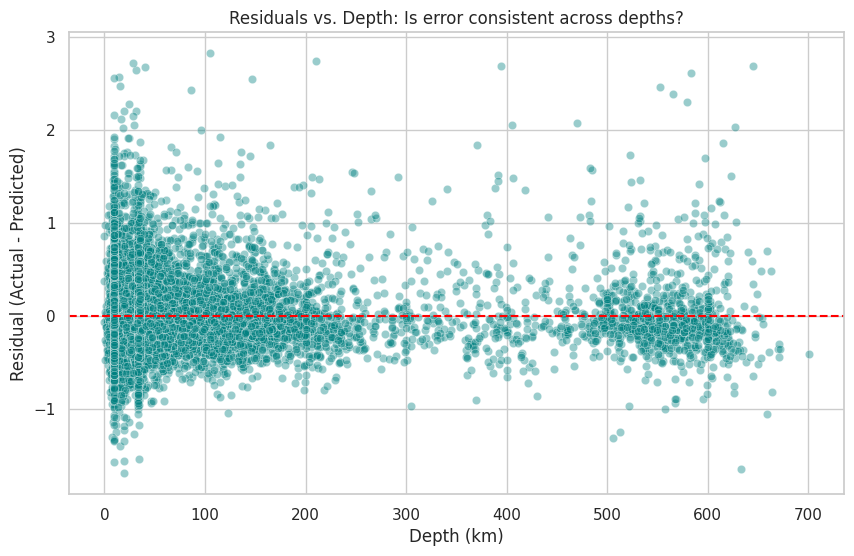

Interpretation:
- Random scatter around the red line is ideal.
- If you see a funnel shape, the model's variance changes with depth (heteroscedasticity).


In [11]:
# Cell 11: Residuals vs. Depth Analysis
plt.figure(figsize=(10, 6))

# Scatter plot of Depth vs Residuals
sns.scatterplot(x=X_test['depth'], y=residuals, alpha=0.4, color='teal')
plt.axhline(0, color='red', linestyle='--')

plt.title("Residuals vs. Depth: Is error consistent across depths?")
plt.xlabel("Depth (km)")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()

print("Interpretation:")
print("- Random scatter around the red line is ideal.")
print("- If you see a funnel shape, the model's variance changes with depth (heteroscedasticity).")

/tmp/ipython-input-981423851.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Magnitude_Class', y='Residuals', data=bias_df, palette="Set3")


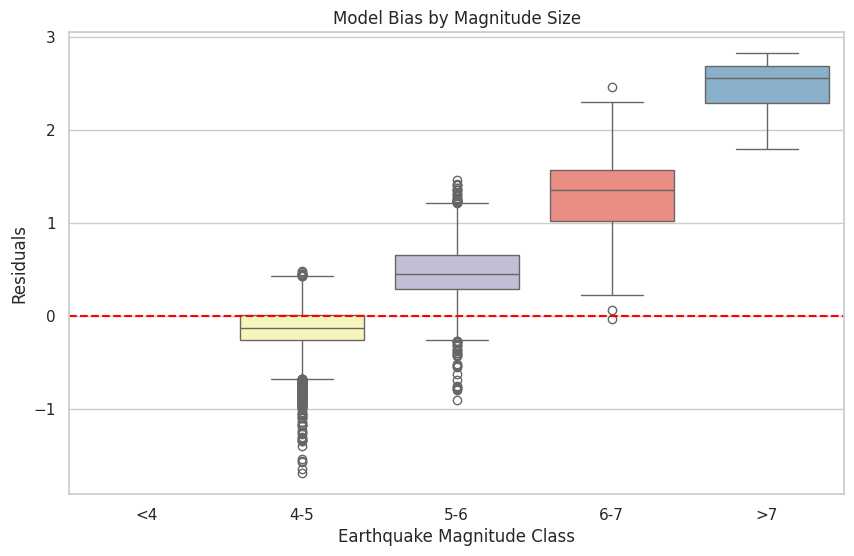

Interpretation:
- Boxes above the red line: Model consistently UNDER-predicts these quakes.
- Boxes below the red line: Model consistently OVER-predicts.


In [12]:
# Cell 12: Error Distribution by Magnitude Class
# Create magnitude bins for the Test set
mag_bins = pd.cut(y_test, bins=[0, 4, 5, 6, 7, 10], labels=['<4', '4-5', '5-6', '6-7', '>7'])

# Create a temporary dataframe for plotting
bias_df = pd.DataFrame({'Magnitude_Class': mag_bins, 'Residuals': residuals})

plt.figure(figsize=(10, 6))
sns.boxplot(x='Magnitude_Class', y='Residuals', data=bias_df, palette="Set3")
plt.axhline(0, color='red', linestyle='--')
plt.title("Model Bias by Magnitude Size")
plt.xlabel("Earthquake Magnitude Class")
plt.ylabel("Residuals")
plt.show()

print("Interpretation:")
print("- Boxes above the red line: Model consistently UNDER-predicts these quakes.")
print("- Boxes below the red line: Model consistently OVER-predicts.")

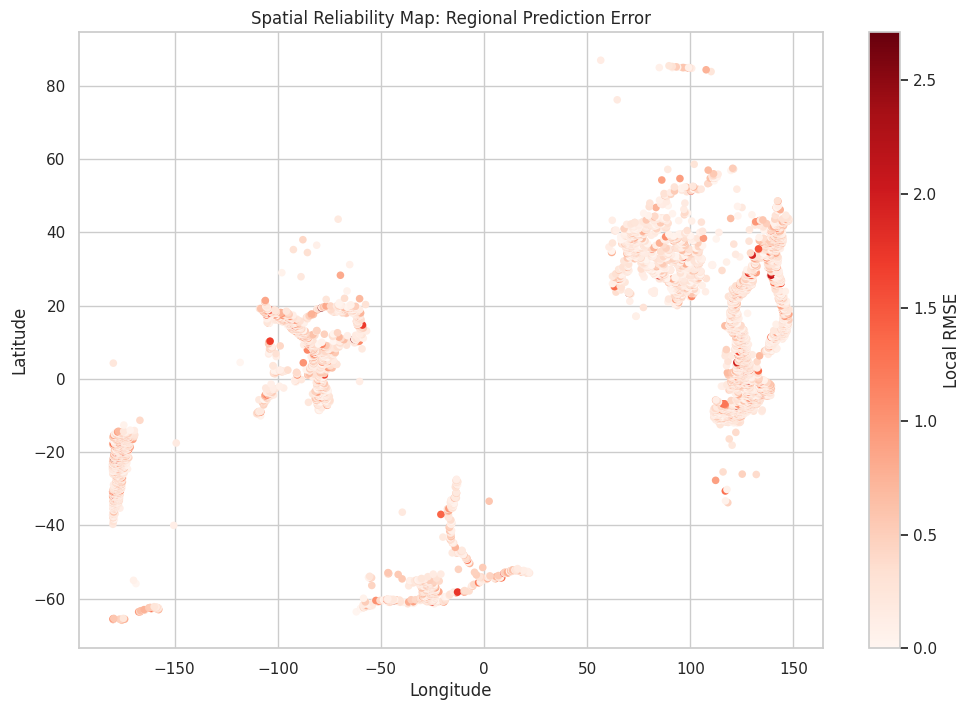

Interpretation: Darker red areas indicate regions where the model is spatially unstable or lacks sufficient training data.


In [13]:
# Cell 13: Local RMSE Map (Spatial Reliability)
# We bin the test data into a spatial grid to calculate local RMSE
test_grid = X_test.copy()
test_grid['lat_bin'] = test_grid['latitude'].round(1) # 0.1 degree bins
test_grid['lon_bin'] = test_grid['longitude'].round(1)
test_grid['sq_error'] = residuals ** 2

# Calculate RMSE per spatial bin
local_rmse = test_grid.groupby(['lat_bin', 'lon_bin'])['sq_error'].mean().pow(0.5).reset_index()

plt.figure(figsize=(12, 8))
sc = plt.scatter(local_rmse['lon_bin'], local_rmse['lat_bin'],
                 c=local_rmse['sq_error'], cmap='Reds', s=30, edgecolors='none')
plt.colorbar(sc, label='Local RMSE')
plt.title("Spatial Reliability Map: Regional Prediction Error")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

print("Interpretation: Darker red areas indicate regions where the model is spatially unstable or lacks sufficient training data.")

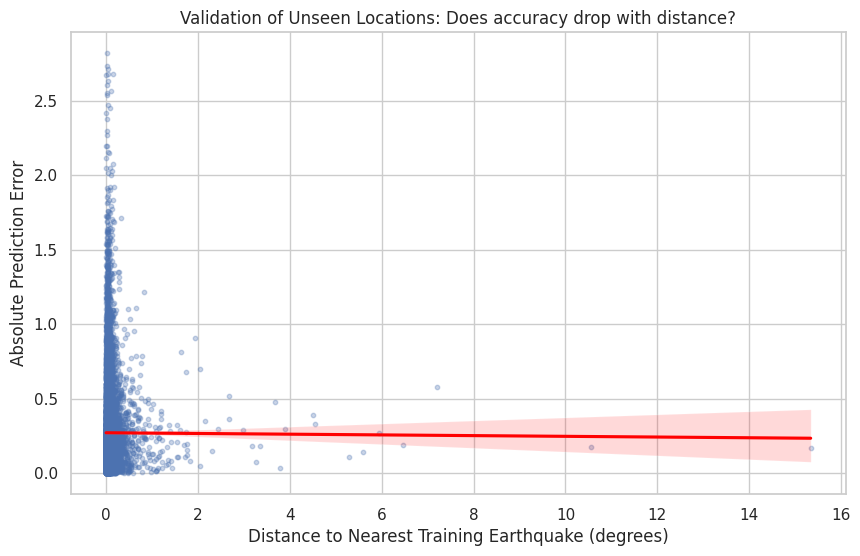

Interpretation:
- A flat red line means the model generalizes well to truly 'unseen' locations.
- An upward slope means the model relies heavily on memorizing nearby points (overfitting).


In [14]:
# Cell 14: Distance Decay of Accuracy
from sklearn.neighbors import NearestNeighbors

# Find distance from each Test point to the nearest Training point
nn = NearestNeighbors(n_neighbors=1)
nn.fit(X_train[['latitude', 'longitude']])
dists, _ = nn.kneighbors(X_test[['latitude', 'longitude']])

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(dists, np.abs(residuals), alpha=0.3, s=10)
sns.regplot(x=dists.flatten(), y=np.abs(residuals), scatter=False, color='red')

plt.title("Validation of Unseen Locations: Does accuracy drop with distance?")
plt.xlabel("Distance to Nearest Training Earthquake (degrees)")
plt.ylabel("Absolute Prediction Error")
plt.show()

print("Interpretation:")
print("- A flat red line means the model generalizes well to truly 'unseen' locations.")
print("- An upward slope means the model relies heavily on memorizing nearby points (overfitting).")

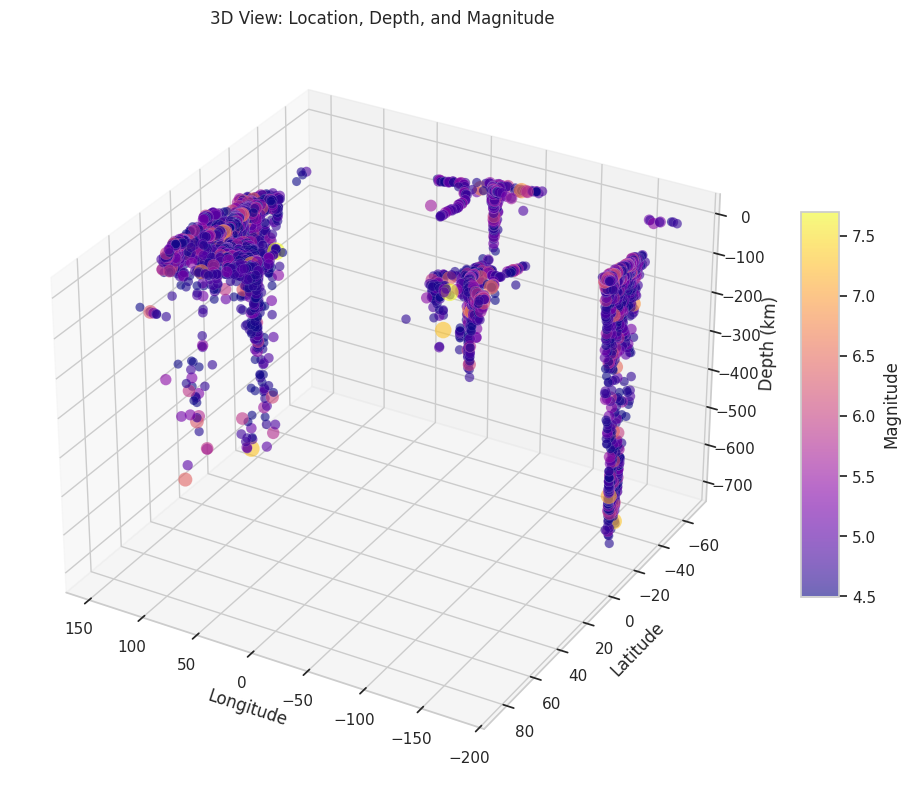

Interpretation:
- This visualizes the 'Subduction Zones' where deep earthquakes (purple/blue dots far below 0) occur.
- Larger, brighter dots are major earthquakes.
- Rotating this mentally helps understand the 3D structure of fault lines.


In [17]:
# Cell 17: 3D Spatio-Temporal Earthquake Plot
from mpl_toolkits.mplot3d import Axes3D

# Sampling for performance (3D plots can be slow with 175k points)
# We take a random sample of 5000 points for a clean visualization
sample_df = df.sample(n=5000, random_state=42)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Axis 1: Longitude (X)
# Axis 2: Latitude (Y)
# Axis 3: Depth (Z) - We invert it because depth goes DOWN
# Color: Magnitude (The target variable)
img = ax.scatter(sample_df['longitude'],
                 sample_df['latitude'],
                 -sample_df['depth'],  # Invert depth for intuitive viewing (ground is 0)
                 c=sample_df['mag'],
                 cmap='plasma',
                 s=sample_df['mag']**2.5, # Size scaled by magnitude for effect
                 alpha=0.6,
                 edgecolors='w', linewidth=0.1)

# Add a color bar
cbar = fig.colorbar(img, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Magnitude')

# Labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth (km)')
ax.set_title('3D View: Location, Depth, and Magnitude')

# Initial View Angle (Elevation, Azimuth)
ax.view_init(elev=30, azim=120)

plt.show()

print("Interpretation:")
print("- This visualizes the 'Subduction Zones' where deep earthquakes (purple/blue dots far below 0) occur.")
print("- Larger, brighter dots are major earthquakes.")
print("- Rotating this mentally helps understand the 3D structure of fault lines.")

/tmp/ipython-input-2242254216.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='season', data=df, order=season_order, palette='Set2', ax=axes[0])
/tmp/ipython-input-2242254216.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='season', y='mag', data=df, order=season_order, palette='Set2', ax=axes[1])


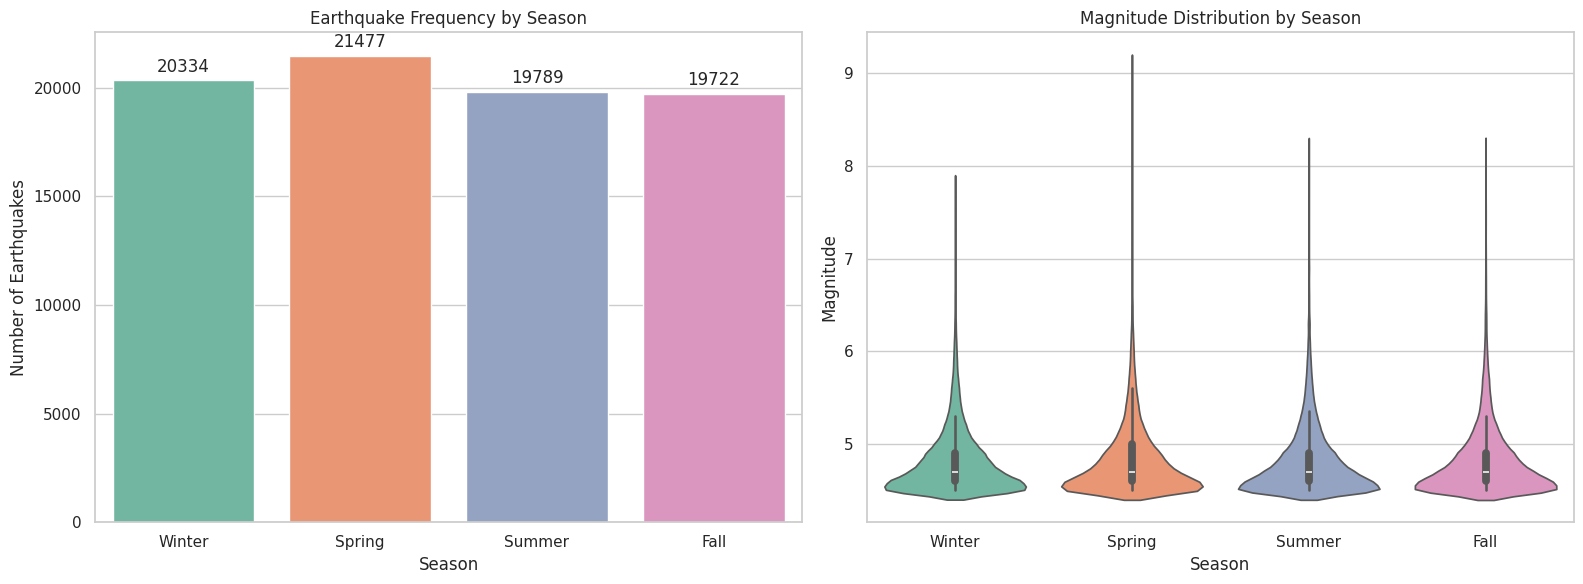

Interpretation:
- Left Plot: Shows if any season has a 'spike' in the number of earthquakes.
- Right Plot: Shows if powerful earthquakes (the 'fat' part of the violin) are more common in a specific season.
- Note: Tectonic processes are usually independent of surface weather, so 'No Trend' is also a valid and expected scientific finding.


In [18]:
# Cell 18: Seasonal Patterns - Frequency and Intensity
# We analyze if Earthquakes have a seasonal component

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Frequency by Season (Bar Chart)
# Order: Winter -> Spring -> Summer -> Fall
season_order = ['Winter', 'Spring', 'Summer', 'Fall']

sns.countplot(x='season', data=df, order=season_order, palette='Set2', ax=axes[0])
axes[0].set_title("Earthquake Frequency by Season")
axes[0].set_xlabel("Season")
axes[0].set_ylabel("Number of Earthquakes")

# Add counts on top of bars
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# 2. Magnitude Distribution by Season (Violin Plot)
# Violin plots are better than boxplots here because they show the DENSITY of data
sns.violinplot(x='season', y='mag', data=df, order=season_order, palette='Set2', ax=axes[1])
axes[1].set_title("Magnitude Distribution by Season")
axes[1].set_xlabel("Season")
axes[1].set_ylabel("Magnitude")

plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Left Plot: Shows if any season has a 'spike' in the number of earthquakes.")
print("- Right Plot: Shows if powerful earthquakes (the 'fat' part of the violin) are more common in a specific season.")
print("- Note: Tectonic processes are usually independent of surface weather, so 'No Trend' is also a valid and expected scientific finding.")

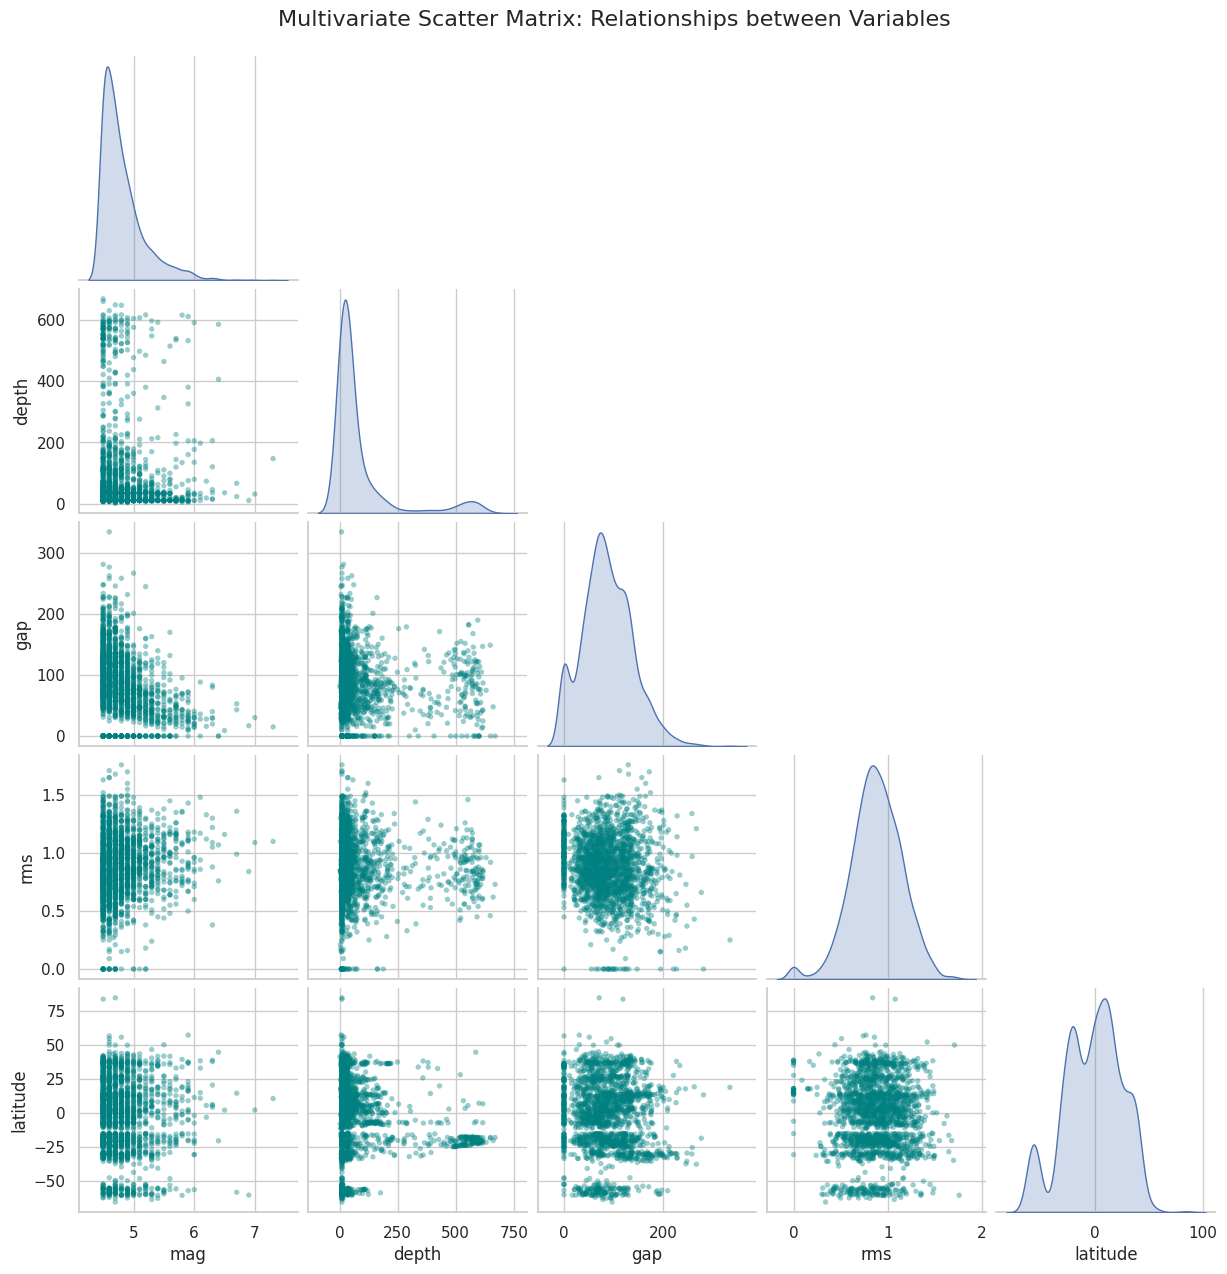

Interpretation:
- Look for 'diagonal' streaks: These indicate strong correlation (e.g., if Depth increases, does RMS increase?).
- Look for 'blobs': These indicate no correlation.
- The diagonal plots show the distribution (histogram) of each single variable.


In [19]:
# Cell 20: Multivariate Scatter Matrix (Pairplot)
# We select the most relevant physical and quality variables
# 'mag': Target variable
# 'depth': Key physical feature
# 'gap': Azimuthal gap (station coverage quality)
# 'rms': Root Mean Square travel time residual (location quality)
# 'latitude': Spatial feature

cols_to_plot = ['mag', 'depth', 'gap', 'rms', 'latitude']

# We take a random sample of 2000 points to ensure the plot is readable and renders quickly
# (Plotting 175k points in a pairplot would be too messy and slow)
sample_df = df[cols_to_plot].sample(n=2000, random_state=42)

# Create the Pairplot
# - diag_kind='kde': Shows the distribution of each variable on the diagonal
# - corner=True: Removes the redundant upper triangle
# - plot_kws: Adjusts transparency (alpha) to show density
g = sns.pairplot(sample_df, diag_kind='kde', corner=True,
                 plot_kws={'alpha': 0.4, 's': 15, 'edgecolor': 'none', 'color': 'teal'})

g.fig.suptitle('Multivariate Scatter Matrix: Relationships between Variables', y=1.02, fontsize=16)
plt.show()

print("Interpretation:")
print("- Look for 'diagonal' streaks: These indicate strong correlation (e.g., if Depth increases, does RMS increase?).")
print("- Look for 'blobs': These indicate no correlation.")
print("- The diagonal plots show the distribution (histogram) of each single variable.")